# Preprocessor + modeling 
train preprocesor for both train and test data, then try out logistic regression  

## Preprocessing 
traint the same preprocessor from last time

In [1]:
import numpy as np
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt

# ensure changes in files are reflected
%load_ext autoreload
%autoreload 2

In [2]:
df = pd.read_csv("../data/processed/3yr_dataset_train.csv")
df = df.drop(columns=['award', 'application_number'])
df.shape

(535, 10)

In [3]:

from sklearn.preprocessing import FunctionTransformer

def binary_homeless(X):
    """Convert homeless percentage to binary (1 if > 0, else 0)."""
    return (X > 0).astype(int)


def get_binary_homeless_transformer():
    """Return a FunctionTransformer for binary_homeless."""
    return FunctionTransformer(
        func=binary_homeless,
        feature_names_out="one-to-one",
    )

In [4]:
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import (
    MinMaxScaler,
    OneHotEncoder,
    PowerTransformer,
    StandardScaler,
)

homeless_pipe = make_pipeline(get_binary_homeless_transformer())

points_transformer = PowerTransformer(method="yeo-johnson")
points_pipe = make_pipeline(points_transformer, MinMaxScaler())

cat_pipe = make_pipeline(OneHotEncoder(sparse_output=False, handle_unknown="ignore"))
remainder_num_pipe = make_pipeline(StandardScaler())

renamed_cat = [
    "construction_type",
    "housing_type",
    "combined_CDLAC_pool",
    "combined_set_aside",
    "CDLAC_region",
]

preprocessor_pipe = ColumnTransformer(
    transformers=[
        ("homeless_binary", homeless_pipe, ["num_homeless_units"]),
        ("points_power", points_pipe, ["total_points"]),
        ("category", cat_pipe, renamed_cat),
    ],
    remainder=remainder_num_pipe,
)


In [5]:
print(df.shape)
# transform
transform_results = preprocessor_pipe.fit_transform(df)

print(transform_results[:3])
print(len(preprocessor_pipe.get_feature_names_out()))
# Convert to DataFrame with column names
df_transformed = pd.DataFrame(
    transform_results, columns=preprocessor_pipe.get_feature_names_out()
)

(535, 10)
[[ 0.          0.81157662  0.          0.          1.          0.
   0.          0.          1.          0.          0.          0.
   0.          0.          1.          0.          0.          0.
   1.          0.          0.          0.          0.          0.
   0.          1.          0.          0.          0.          0.
   0.         -0.26526267 -0.39216617  0.77245662]
 [ 1.          0.81157662  0.          0.          1.          0.
   0.          0.          0.          0.          0.          1.
   0.          0.          1.          0.          0.          0.
   0.          0.          1.          0.          0.          0.
   0.          1.          0.          0.          0.          0.
   0.         -0.57840528 -0.45983673 -0.1476575 ]
 [ 0.          1.          0.          0.          1.          0.
   0.          1.          0.          0.          0.          0.
   0.          0.          1.          0.          0.          0.
   0.          0.          0. 

In [6]:
df_transformed.head()

,homeless_binary__num_homeless_units,points_power__total_points,category__construction_type_ACQ AND REHAB,category__construction_type_ADAPTIVE REUSE,category__construction_type_NEW CONSTRUCTION,category__construction_type_REHABILITATION,category__housing_type_At-Risk,category__housing_type_Large Family,category__housing_type_Non-Targeted,category__housing_type_SRO,...,category__CDLAC_region_BALANCE OF LA COUNTY,category__CDLAC_region_BAY AREA,category__CDLAC_region_CITY OF LA,category__CDLAC_region_COASTAL,category__CDLAC_region_INLAND,category__CDLAC_region_NONE,category__CDLAC_region_NORTHERN,remainder__avg_targeted_affordability,remainder__tie_breaker_self_score,remainder__bond_request_amount
0,0.0,0.811577,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,-0.265263,-0.392166,0.772457
1,1.0,0.811577,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,-0.578405,-0.459837,-0.147658
2,0.0,1.000000,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.264941,-0.952675,-0.598680
3,0.0,1.000000,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,-0.253534,-0.430495,1.302401
4,0.0,0.113694,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,-0.006892,1.614036,0.285473


In [7]:
df_transformed.to_csv("../data/processed/3yr_features.csv")

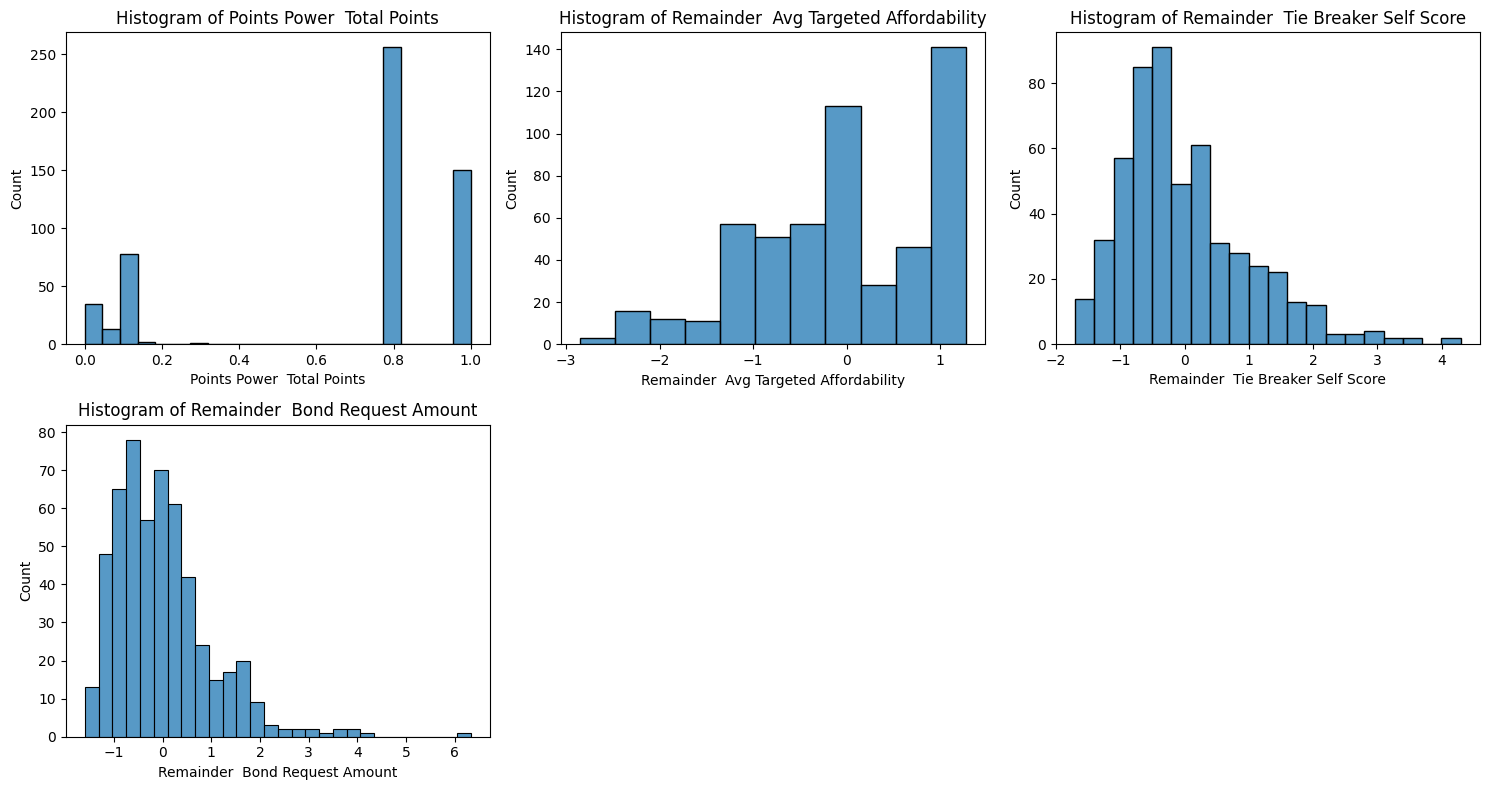

In [8]:
# Define the features to plot
numeric = ['points_power__total_points', 'remainder__avg_targeted_affordability', 'remainder__tie_breaker_self_score', 'remainder__bond_request_amount']

# Create a figure with subplots (2 rows, 3 columns to accommodate 5 features)
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(15, 8))

# Flatten axes array for easier iteration (since we have 5 plots, not 6)
axes = axes.flatten()

# Plot a histogram for each feature
for i, feature in enumerate(numeric):
    sb.histplot(data=df_transformed, x=feature, ax=axes[i])
    axes[i].set_xlabel(feature.replace('_', ' ').title())  # Nicer label
    axes[i].set_ylabel('Count')
    axes[i].set_title(f'Histogram of {feature.replace("_", " ").title()}')

# Remove the empty subplot (if any)
for j in range(len(numeric), len(axes)):
    fig.delaxes(axes[j])

# Adjust layout to prevent overlap
plt.tight_layout()

# Show the plot
plt.show()

### notes
As you can see the transformed features are similar in scale and distribution for total points is slightly less skewed. 

In [9]:
import joblib
joblib.dump(preprocessor_pipe, "../models/3yr-preprocessor.pkl")

['../models/3yr-preprocessor.pkl']

## Modeling

Lets try training the same model we used previously, a logistic regression model. 

In [21]:
X_train = pd.read_csv("../data/processed/3yr_dataset_train.csv").drop(columns=['award','application_number'])
y_train = pd.read_csv("../data/processed/3yr_dataset_train.csv")['award'].map({"Yes": 1, "No":0})
print(X_train.shape, y_train.shape)
preprocessor_pipe = joblib.load("../models/3yr-preprocessor.pkl")

(535, 10) (535,)


In [22]:
from sklearn.ensemble import RandomForestClassifier

full_pipeline = make_pipeline(preprocessor_pipe, RandomForestClassifier(random_state=42))
full_pipeline.fit(X_train, y_train)

,steps,"[('columntransformer', ...), ('randomforestclassifier', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('homeless_binary', ...), ('points_power', ...), ...]"
,remainder,Pipeline(step...ardScaler())])
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [23]:
from sklearn.metrics import classification_report

y_train_pred = full_pipeline.predict(X_train)
print(classification_report(y_train, y_train_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       293
           1       1.00      1.00      1.00       242

    accuracy                           1.00       535
   macro avg       1.00      1.00      1.00       535
weighted avg       1.00      1.00      1.00       535



In [24]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import f1_score, classification_report

full_pipeline = make_pipeline(preprocessor_pipe, DecisionTreeClassifier(random_state=42, max_depth=2))
full_pipeline.fit(X_train, y_train)
y_train_pred = full_pipeline.predict(X_train)
print(classification_report(y_train, y_train_pred))
print(f1_score(y_train, y_train_pred))


              precision    recall  f1-score   support

           0       0.73      0.69      0.71       293
           1       0.65      0.69      0.67       242

    accuracy                           0.69       535
   macro avg       0.69      0.69      0.69       535
weighted avg       0.69      0.69      0.69       535

0.668


In [25]:
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.metrics import f1_score
def f1_scores_comparision(y_train_pred, model, X):
    train_f1 = f1_score(y_train, y_train_pred)
    print(f"Train             F1 score: {train_f1:.3f}")
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    scores = cross_val_score(model, X, y_train, cv=cv, scoring='f1')
    print(f"Cross-validation F1 scores: {scores.mean():.3f} ± {scores.std():.3f}")

In [32]:
from sklearn.pipeline import make_pipeline
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report

# List of classifiers with default settings (except random_state)
classifiers = [
    ('Logistic Regression', LogisticRegression(random_state=42)),
    ('Decision Tree', DecisionTreeClassifier(random_state=42, max_depth=2)),
    ('Random Forest', RandomForestClassifier(random_state=42, max_depth=7)),
    ('Support Vector Classifier', SVC(random_state=42)),
    ('K-Neighbors Classifier', KNeighborsClassifier())
]

# Loop through classifiers, train, predict, and print classification report
for name, clf in classifiers:
    print(f"\n=== {name} ===")
    full_pipeline = make_pipeline(preprocessor_pipe, clf)
    full_pipeline.fit(X_train, y_train)
    y_train_pred = full_pipeline.predict(X_train)
    # print(classification_report(y_train, y_train_pred))
    f1_scores_comparision(y_train_pred, full_pipeline, X_train)


=== Logistic Regression ===
Train             F1 score: 0.651
Cross-validation F1 scores: 0.583 ± 0.076

=== Decision Tree ===
Train             F1 score: 0.668
Cross-validation F1 scores: 0.636 ± 0.057

=== Random Forest ===
Train             F1 score: 0.825
Cross-validation F1 scores: 0.628 ± 0.059

=== Support Vector Classifier ===
Train             F1 score: 0.689
Cross-validation F1 scores: 0.590 ± 0.070

=== K-Neighbors Classifier ===
Train             F1 score: 0.704
Cross-validation F1 scores: 0.495 ± 0.031


# Model Performance Metrics

| Model                     | Train F1 Score | Cross-validation F1 Scores |
|---------------------------|----------------|----------------------------|
| Logistic Regression       | 0.651          | 0.583 ± 0.076              |
| Decision Tree             | 1.000          | 0.605 ± 0.067              |
| Random Forest             | 1.000          | 0.610 ± 0.054              |
| Support Vector Classifier | 0.689          | 0.590 ± 0.070              |
| K-Neighbors Classifier    | 0.704          | 0.495 ± 0.031              |

- After trying 5 default models, we notice a few things:
  - the average CV f1 score is higher, with 2 models reaching 0.6. Previously with just 70 data points, the CV F1 score is <0.5 for all models. 
  - The standard deviation are all less than +- 0.1 too
  - Logistic Regression and SVM look like promising models to fine tune
  - Decision Tree and Random Forest are clearly overfitted
- Limitting depth of the trees seem to have good results

| Model                     | Train F1 Score | Cross-validation F1 Scores |
|---------------------------|----------------|----------------------------|
| Decision Tree (max_depth=2) | 0.668          | 0.636 ± 0.057              |